# Image-to-Text Image Captioning 模型
参考文档: [https://huggingface.co/nlpconnect/vit-gpt2-image-captioning](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning)  
有两种调用方法，分别是下文中的 Sample running code 和 Sample running code using transformers pipeline  
推荐使用第一种方法。一般来说，前者的效果要比后者好一些

# 数据样例
来源于 [PhotoChat](https://aclanthology.org/2021.acl-long.479/) 数据集中的图像
1.  url: https://farm7.staticflickr.com/1198/869496755_25e16979f7_o.jpg  
    本地相对路径: "data/869496755_25e16979f7_o.jpg"  
2.  url: https://farm5.staticflickr.com/3241/2928579634_14c86c18dc_o.jpg  
    本地相对路径: "data/2928579634_14c86c18dc_o.jpg"
3.  url: https://c3.staticflickr.com/3/2773/4378396785_88708c4986_o.jpg  
    本地相对路径: "data/4378396785_88708c4986_o.jpg"    

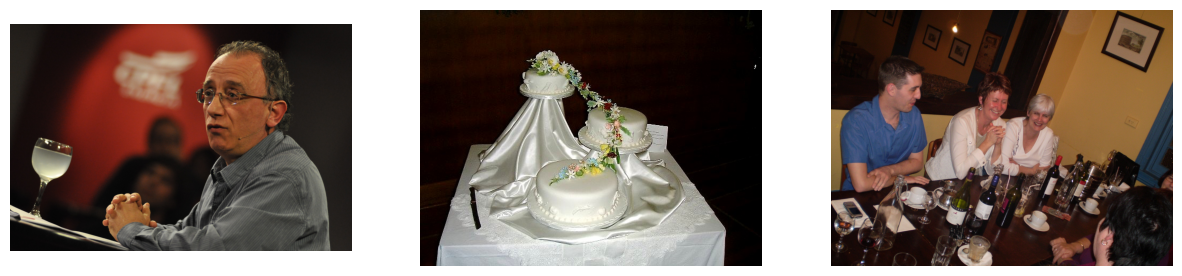

In [1]:
# 显示图片
import os
from PIL import Image
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 15))
for i, image_path in enumerate(os.listdir("data")):
    image_path = os.path.join("data", image_path)
    image = Image.open(image_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

# Sample running code

In [2]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
import warnings

warnings.filterwarnings('ignore')

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/data/kfh/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [3]:
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds

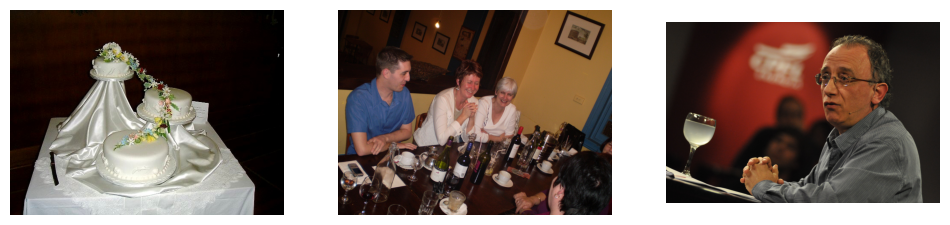

['a wedding cake with flowers on a table', 'people sitting at a table with wine glasses', 'a man holding a wine glass in his right hand']


In [4]:
images_path = ["data/869496755_25e16979f7_o.jpg", "data/2928579634_14c86c18dc_o.jpg", "data/4378396785_88708c4986_o.jpg"]
plt.figure(figsize=(12, 12))
for i, image_path in enumerate(images_path):
    image = Image.open(image_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

images_caption1 = predict_step(images_path)
print(images_caption1)

# Sample running code using transformers pipeline

In [5]:
from transformers import pipeline

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

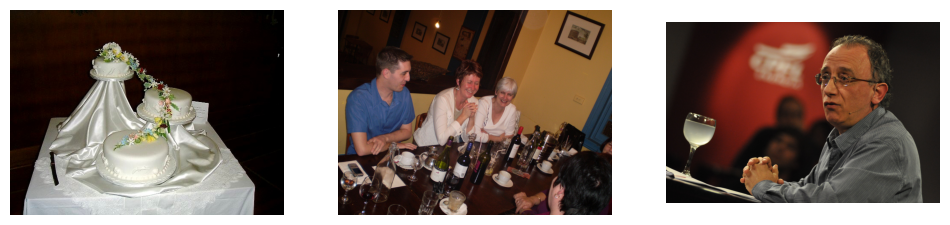

[[{'generated_text': 'a wedding cake with flowers on a table '}], [{'generated_text': 'people sitting around a table '}], [{'generated_text': 'a man holding a tennis racket in his right hand '}]]


In [6]:
images_path = ["data/869496755_25e16979f7_o.jpg", "data/2928579634_14c86c18dc_o.jpg", "data/4378396785_88708c4986_o.jpg"]
plt.figure(figsize=(12, 12))
for i, image_path in enumerate(images_path):
    image = Image.open(image_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

images_caption2 = image_to_text(images_path)  # 这种调用方法中的路径也可以是 url网址
print(images_caption2)

# 两种方法对比

|图像|生成的图像描述(第一种调用方法)|生成的图像描述(第二种调用方法)|对比|
|:-:|:-:|:-:|:-:|
|data/869496755_25e16979f7_o.jpg|a wedding cake with flowers on a table|a wedding cake with flowers on a table|相同|
|data/2928579634_14c86c18dc_o.jpg|people sitting at a table with wine glasses|people sitting around a table|第一种更好|
|data/4378396785_88708c4986_o.jpg|a man holding a wine glass in his right hand|a man holding a tennis racket in his right hand|第一种更好|

分析: 可能是因为 feature_extractor 的影响使第一种调用方法更加准确，不过本人先前没做过 image2text 的相关工作，分析的可能并不到位。